# NLP with NLTK and Word2Vec

Here we're working with the preprocessed movies dataset to figure out how to map these descriptions into some subspace of interest.

In [1]:
import gensim
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### NLTK packages

In [2]:
nltk.download('punkt')
# download stop words using nltk
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/Greg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Greg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Import NLP dataset

In [35]:
df = (pd.read_csv("df_nlp_greg.csv", header=0, sep=',', encoding='latin-1')
    .dropna(subset=['title', 'id', 'overview'])
    .drop('original_title', axis=1)
    .set_index('title'))

In [55]:
print(df.shape)

(20426, 4)


### Set to lowercase

In [36]:
df['overview'] = df['overview'].str.lower()

### Remove fullstop endings

In [37]:
df.loc[df['overview'].str.endswith('.'), 'overview'] = df.loc[df['overview'].str.endswith('.'), 'overview'].str[:-1]

### Tokenize sentences

In [38]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [39]:
df['overview_tokens'] = df['overview'].apply(tokenizer.tokenize).apply(lambda x: ' '.join(x))

### Expand

In [40]:
# expand out
overview_exp = df['overview_tokens'].str.split(" ", expand=True)

### Using NLTK corpora of English *stop words* to filter

In [41]:
from nltk.corpus import stopwords

In [42]:
stop = stopwords.words('english')

In [43]:
filter_w = "^(?:" + "|".join(stop).replace("'", "\'") + '|\s)$'

In [44]:
filter_w

"^(?:i|me|my|myself|we|our|ours|ourselves|you|you're|you've|you'll|you'd|your|yours|yourself|yourselves|he|him|his|himself|she|she's|her|hers|herself|it|it's|its|itself|they|them|their|theirs|themselves|what|which|who|whom|this|that|that'll|these|those|am|is|are|was|were|be|been|being|have|has|had|having|do|does|did|doing|a|an|the|and|but|if|or|because|as|until|while|of|at|by|for|with|about|against|between|into|through|during|before|after|above|below|to|from|up|down|in|out|on|off|over|under|again|further|then|once|here|there|when|where|why|how|all|any|both|each|few|more|most|other|some|such|no|nor|not|only|own|same|so|than|too|very|s|t|can|will|just|don|don't|should|should've|now|d|ll|m|o|re|ve|y|ain|aren|aren't|couldn|couldn't|didn|didn't|doesn|doesn't|hadn|hadn't|hasn|hasn't|haven|haven't|isn|isn't|ma|mightn|mightn't|mustn|mustn't|needn|needn't|shan|shan't|shouldn|shouldn't|wasn|wasn't|weren|weren't|won|won't|wouldn|wouldn't|\\s)$"

## Filter out words

In [45]:
repl = overview_exp.replace(filter_w, np.nan, regex=True).replace('', np.nan)

In [46]:
list_lists = repl.apply(lambda x: x.str.cat(sep=';'), axis=1).str.split(';')

In [47]:
print(repl.shape)
repl.head()

(20426, 308)


,0,1,2,3,4,5,6,7,8,9,...,298,299,300,301,302,303,304,305,306,307
title,,,,,,,,,,,,,,,,,,,,,
Jumanji,NaN,siblings,judy,NaN,peter,discover,NaN,enchanted,board,game,...,None,None,None,None,None,None,None,None,None,None
Grumpier Old Men,NaN,family,wedding,reignites,NaN,ancient,feud,NaN,next,door,...,None,None,None,None,None,None,None,None,None,None
Waiting to Exhale,cheated,NaN,mistreated,NaN,stepped,NaN,NaN,women,NaN,holding,...,None,None,None,None,None,None,None,None,None,None
Father of the Bride Part II,NaN,NaN,george,banks,NaN,recovered,NaN,NaN,daughter,NaN,...,None,None,None,None,None,None,None,None,None,None
Heat,obsessive,master,thief,neil,mccauley,leads,NaN,top,notch,crew,...,None,None,None,None,None,None,None,None,None,None


In [48]:
word2vec_ready = list_lists.tolist()

## Deploying Word2Vec

In [49]:
model = gensim.models.Word2Vec(word2vec_ready, min_count=1, size=50, workers=3, window=3, sg=1)

In [66]:
X = model.wv[model.wv.vocab]

### Project using PCA

In [51]:
from sklearn.decomposition import PCA

In [52]:
pca_t = PCA(2).fit_transform(X)

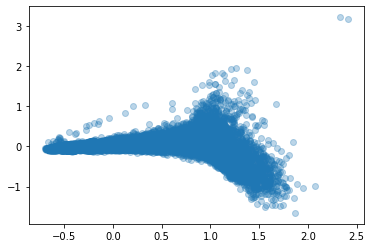

In [53]:
plt.scatter(pca_t[:, 0], pca_t[:, 1],alpha=.3)
plt.show()

### Most similar

In [56]:
model.most_similar('victory')[:10]

//anaconda/envs/hacksouth/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('alternate', 0.9888033866882324),
 ('climactic', 0.9886969923973083),
 ('otherworldly', 0.986829400062561),
 ('atmosphere', 0.9866527318954468),
 ('reaction', 0.9865977168083191),
 ('villains', 0.9865387678146362),
 ('describes', 0.9863992929458618),
 ('spawned', 0.986178994178772),
 ('encountered', 0.9858294129371643),
 ('murky', 0.9856820106506348)]